In [29]:
using LinearAlgebra
using Plots
using Random
using Statistics
using Distributions
using CSV
using DataFrames
using PlutoUI
using GaussianProcesses
using ProgressMeter

## Contagios de COVID-19 en la CDMX desde el 31/12/2019 al 02/06/2021

Datos recuperados de [Covid-19 México Trámites Gobierno](https://datos.covid-19.conacyt.mx/#DOView)

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\danie\.julia\packages\Plots\vsE7b\src\args.jl:862


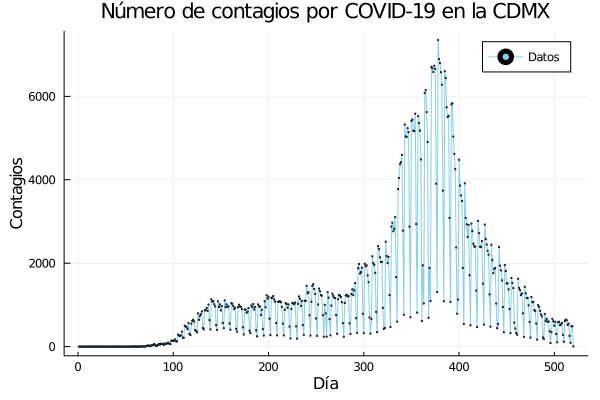

In [5]:
df = CSV.read("covid19.csv", DataFrame)

plot(1:520, df[:, 2], xlabel="Día", ylabel="Contagios",
	title="Número de contagios por COVID-19 en la CDMX",
	color="skyblue", marker="o", markersize=1, label="Datos")

Definimos algunos parámetros, así como los conjunto de entrenamiento y de prueba del algortimo

In [9]:
a, b, n = 0, 350, 1000;

N = 520;

x_train = collect(1:b) / 100;
y_train = df[1:b, 2] / 1000;
x_test = collect(range(a, N, length=n)) / 100;

Definimos el Kernel

$$K_{i, j} = k(x_i, x_j) = \eta \cdot e^{-\frac{1}{2l^2}|x_i - x_j|^2}$$

In [40]:
η = 8e-3
l, σ² = 0.49, 1e-4

kernel(A, B, l) = [η * exp(-(1 / (2 * l^2)) * 
		norm(i - j)^2) + 1e-4 for i in A, j in B]

kernel (generic function with 1 method)

Definimos las matrices de covarianza entre `x_train` y `x_test`

In [41]:
K = kernel(x_train, x_train, l) + σ²*I(b);
K_x = kernel(x_train, x_test, l);
K_xx = kernel(x_test, x_test, l);

Creamos las funciones previas, para ello, obtenemos la descomposición de Cholesky de K_xx

In [42]:
L_xx = cholesky(K_xx + 1e-10 * I(n));

Creamos la función previa sobre el conjunto de prueba antes de observar los datos

In [43]:
f_prior  = L_xx.U * rand(Normal(), (n, 5));

Calaculamos la funcion $\mu(x)$ y $\Sigma(x)$ del Proceso Gaussiano $\mathcal{GP}(\mu, \Sigma)$

In [44]:
μ = K_x' * inv(K) * y_train;
Σ = K_xx - K_x' * inv(K) * K_x;
stdv = [sum(Σ[i, :]) for i in 1:n];

Una vez que tenemos la funcón media y covarianza, le mostramos al modelo los nuevos datos,  para luego crear las funciones posteriores

In [45]:
f_post = μ .+ Σ * rand(Normal(), (n, 5));

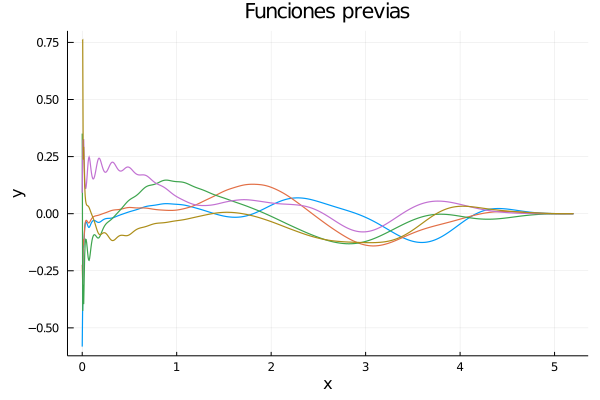

In [46]:
plot(x_test, f_prior[:, :], label="", lw=1.2, xlabel="x", ylabel="y",
	title="Funciones previas")

Los valores que se adaptan a la regresión que estamos buscando son `l = 0.49` y `σ² = 0.0001`

┌ Warning: Skipped marker arg ..
└ @ Plots C:\Users\danie\.julia\packages\Plots\vsE7b\src\args.jl:862


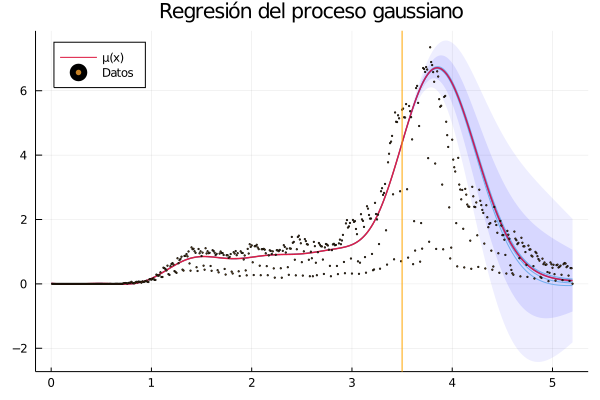

In [47]:
plot(x_test, f_post[:, :], label="", color="skyblue", legend=:topleft)
plot!(x_test, μ,
      ribbon=(2abs.(stdv)), fillalpha=0.07, fillcolor="blue",
      lw=1.5,
      color="crimson",
      label="μ(x)",
      title="Regresión del proceso gaussiano")
plot!(x_test, μ, label="", lw=0.1,
      ribbon=(abs.(stdv)), fillalpha=0.1, fillcolor="blue")
scatter!(collect(1:520)/100, df[:, 2]/1000,
         marker=".", markersize=0.85, label="Datos")
vline!([3.5], label="", color="orange")

Como la distribución normal que estamos ajustando depende de los parametros $\sigma^2$ y $l$, definimos ahora la función de máxima verosimilitud.

Al minimizar esta función estaremos optimizando dichos parámetros.

In [24]:
function Marginal_likelihood(l, σ²)
	
	K = kernel(x_train, x_train, l) + σ²*I(b)
	
	return (0.5 * y_train' * inv(K) * y_train + 
			0.5 * log(det(K)) + (b/2) * log(2π))^0.5
end

Marginal_likelihood (generic function with 1 method)

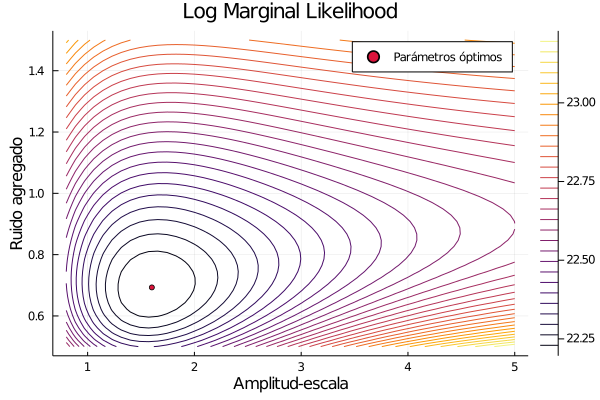

In [25]:
contour((range(0.8, 5, length=50)),
        collect(range(0.5, 1.5, length=50)),
        levels=30,
        Marginal_likelihood,
        title="Log Marginal Likelihood",
        xlabel="Amplitud-escala", ylabel="Ruido agregado")
scatter!([1.60141], [0.69306], color="Crimson",
         label="Parámetros óptimos", markersize=3)

Para maximizar la función de máxima verosimilitud, minimizaremos el negativo de dicha función mediante el algoritmo del descenso del gradiente.

In [30]:
function ∇(f, x₀, x₁, h)
	(1/2h) * [f(x₀ + h, x₁) - f(x₀ - h, x₁), f(x₀, x₁ + h) - f(x₀, x₁ - h)]
end

function gradient_descent(f, α, ϵ, n)
	
	x₀, x₁ = 5rand(2) #Punto inicial del algoritmo
	h = 1e-7
	
	@showprogress for i in 1:n
		x₀, x₁ = [x₀, x₁] - α * ∇(f, x₀, x₁, h)
	end
	
	x₀, x₁, f(x₀, x₁), norm(∇(f, x₀, x₁, h))
	
end

gradient_descent (generic function with 1 method)

In [31]:
opt = gradient_descent(Marginal_likelihood, 7e-2, 1e-4, 1000)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:299m


(1.6014136238545817, 0.6930597029383945, 22.19580947641374, 0.0)

Ahora que tenemos los parámetros óptimos, podemos graficar la regresión.